In [2]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
import subprocess
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
def install_required_packages():
    """Install required packages if not already installed"""
    packages = ['google-play-scraper', 'ollama', 'matplotlib', 'seaborn', 'wordcloud', 'play-scraper']
    
    for package in packages:
        try:
            __import__(package.replace('-', '_'))
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_required_packages()

In [4]:
from google_play_scraper import app, reviews, Sort
import ollama
from wordcloud import WordCloud
import play_scraper

In [5]:
APP_ID = "com.kiya.mahaplus"
MAX_REVIEWS = 200
LANGUAGE = 'en'
COUNTRY = 'in'

In [6]:
def fetch_app_info_multiple_methods(app_id):
    """Fetch app info using multiple methods"""
    print("Fetching app information...")
    
    try:
        # Method 1: google-play-scraper
        app_info = app(app_id, lang=LANGUAGE, country=COUNTRY)
        print("✅ Success with google-play-scraper")
        print(f"App Name: {app_info['title']}")
        print(f"Developer: {app_info['developer']}")
        print(f"Overall Score: {app_info['score']}")
        print(f"Installs: {app_info['installs']}")
        return app_info
    except Exception as e:
        print(f"❌ google-play-scraper failed: {e}")
    
    try:
        # Method 2: play-scraper
        app_info = play_scraper.details(app_id)
        print("✅ Success with play-scraper")
        print(f"App Name: {app_info['title']}")
        print(f"Developer: {app_info['developer']}")
        print(f"Score: {app_info['score']}")
        print(f"Installs: {app_info['installs']}")
        return app_info
    except Exception as e:
        print(f"❌ play-scraper failed: {e}")
    
    return None


In [9]:
def fetch_reviews_advanced(app_id, max_reviews=200):
    """
    Advanced review fetching with multiple strategies
    """
    print("🔄 Trying different review fetching strategies...")
    
    all_reviews = []
    
    # Strategy 1: Try without score filter first
    print("Strategy 1: Fetching all reviews (no score filter)...")
    try:
        result, _ = reviews(
            app_id,
            lang=LANGUAGE,
            country=COUNTRY,
            sort=Sort.NEWEST,
            count=100
        )
        if result:
            all_reviews.extend(result)
            print(f"✅ Got {len(result)} reviews without filter")
    except Exception as e:
        print(f"❌ Strategy 1 failed: {e}")
    
    time.sleep(2)
    
    # Strategy 2: Try with MOST_RELEVANT sort
    print("Strategy 2: Fetching with MOST_RELEVANT sort...")
    try:
        result, _ = reviews(
            app_id,
            lang=LANGUAGE,
            country=COUNTRY,
            sort=Sort.MOST_RELEVANT,
            count=100
        )
        if result:
            all_reviews.extend([r for r in result if r not in all_reviews])
            print(f"✅ Got {len(result)} additional reviews")
    except Exception as e:
        print(f"❌ Strategy 2 failed: {e}")
    
    time.sleep(2)
    
    # Strategy 3: Try different language/country
    print("Strategy 3: Trying different regions...")
    for lang, country in [('en', 'us'), ('en', 'gb'), ('en', 'in')]:
        try:
            result, _ = reviews(
                app_id,
                lang=lang,
                country=country,
                sort=Sort.NEWEST,
                count=50
            )
            if result:
                all_reviews.extend([r for r in result if r not in all_reviews])
                print(f"✅ Got {len(result)} reviews from {country}")
                if len(all_reviews) >= max_reviews:
                    break
        except Exception as e:
            print(f"❌ Region {country} failed: {e}")
        time.sleep(1)
    
    # Remove duplicates based on reviewId
    unique_reviews = {}
    for review in all_reviews:
        unique_reviews[review['reviewId']] = review
    
    final_reviews = list(unique_reviews.values())
    
    print(f"📊 Total unique reviews fetched: {len(final_reviews)}")
    
    # Filter for negative reviews (1-2 stars)
    negative_reviews = [r for r in final_reviews if r['score'] in [1, 2]]
    print(f"🔴 Negative reviews (1-2 stars): {len(negative_reviews)}")
    
    return negative_reviews[:max_reviews]


In [10]:
def manual_review_search():
    """
    Manual approach - simulate some common negative reviews based on typical banking app issues
    This is a fallback when scraping fails
    """
    print("🛠️ Using manual review simulation based on common banking app issues...")
    
    # Common complaints for banking apps (based on typical patterns)
    common_complaints = [
        "App keeps crashing when trying to login. Very frustrating!",
        "OTP not receiving. Unable to complete any transaction.",
        "After update, app stopped working completely. Waste of time.",
        "Transaction failed but amount deducted from account. No customer support.",
        "Very slow app. Takes 5 minutes just to check balance.",
        "User interface is very confusing. Can't find basic features.",
        "Fingerprint login not working. Have to use password every time.",
        "App logs out automatically after 2 minutes. Very annoying.",
        "Cannot view transaction history properly. Shows error every time.",
        "Fund transfer failing with technical error. Need immediate fix.",
        "Update made the app worse than before. Now it's unusable.",
        "Customer service is useless. They don't resolve app issues.",
        "App not compatible with my phone after latest Android update.",
        "Security concerns - app asking for too many permissions.",
        "Notification not working for transactions. Missed important alerts.",
        "Login problem - says invalid credentials but website works fine.",
        "App freezes during payment process. Have to force close.",
        "Biometric authentication failed multiple times. Very unreliable.",
        "Cannot download account statement. Always shows error.",
        "App design is terrible. Buttons don't respond properly."
    ]
    
    simulated_reviews = []
    for i, complaint in enumerate(common_complaints):
        simulated_reviews.append({
            'reviewId': f'simulated_{i}',
            'content': complaint,
            'score': 1 if i % 3 == 0 else 2,  # Mix of 1 and 2 stars
            'thumbsUpCount': i % 10,
            'at': datetime.now(),
            'reply_content': None,
            'review_created_version': 'Varies'
        })
    
    print(f"📝 Generated {len(simulated_reviews)} simulated reviews based on common banking app issues")
    return simulated_reviews


In [11]:
def fetch_reviews_with_fallback(app_id, max_reviews=200):
    """
    Try multiple methods to get reviews with fallback to simulated data
    """
    print("🔄 Attempting to fetch real reviews from Play Store...")
    
    try:
        reviews_data = fetch_reviews_advanced(app_id, max_reviews)
        
        if reviews_data and len(reviews_data) > 10:
            print(f"✅ Successfully fetched {len(reviews_data)} real negative reviews")
            return reviews_data
        else:
            print("⚠️  Few real reviews found, supplementing with simulated data")
            real_reviews = reviews_data if reviews_data else []
            simulated_reviews = manual_review_search()
            
            # Combine real and simulated reviews
            combined = real_reviews + simulated_reviews
            return combined[:max_reviews]
            
    except Exception as e:
        print(f"❌ All review fetching methods failed: {e}")
        print("🛠️ Using simulated reviews for analysis")
        return manual_review_search()


In [12]:
def analyze_with_ollama_improved(reviews_text, model_name="llama2"):
    """
    Improved analysis with better error handling and fallbacks
    """
    max_retries = 3
    retry_delay = 5
    
    for attempt in range(max_retries):
        try:
            print(f"🔄 Attempt {attempt + 1} to analyze with Ollama...")
            
            # Check Ollama availability
            available_models = ollama.list()
            if not available_models['models']:
                print("❌ No Ollama models available. Please run: ollama pull llama2")
                return None
            
            print(f"✅ Using model: {model_name}")
            
            # Limit text to avoid token limits
            combined_reviews = "\n---\n".join(reviews_text[:40])[:3000]
            
            prompt = f"""
            Analyze these negative Play Store reviews for Bank of Maharashtra's MahaMobile banking app:

            {combined_reviews}

            Provide a detailed analysis focusing on:

            CRITICAL ISSUES:
            - What are the most severe problems preventing basic banking?
            - Which issues affect financial transactions or security?

            TECHNICAL PROBLEMS:
            - App crashes, performance issues, bugs
            - Login/authentication failures
            - OTP/SMS delivery issues
            - Transaction failures

            USER EXPERIENCE:
            - UI/UX design flaws
            - Navigation difficulties
            - Feature accessibility problems

            FUNCTIONAL ISSUES:
            - Specific banking features not working
            - Account management problems
            - Transaction history issues

            SECURITY CONCERNS:
            - Any security or privacy issues mentioned

            RECOMMENDATIONS:
            - Immediate priority fixes
            - User experience improvements
            - Technical debt to address

            Be specific and practical in your analysis.
            """
            
            response = ollama.generate(model=model_name, prompt=prompt)
            print("✅ Analysis completed successfully")
            return response['response']
            
        except Exception as e:
            print(f"❌ Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                print(f"⏳ Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("❌ All analysis attempts failed")
                return None


In [13]:
def create_comprehensive_analysis(reviews_data):
    """
    Create comprehensive analysis with visualizations
    """
    if not reviews_data:
        print("❌ No reviews data to analyze")
        return
    
    df = pd.DataFrame(reviews_data)
    
    print("\n📊 REVIEW ANALYSIS SUMMARY:")
    print("=" * 50)
    print(f"Total Reviews: {len(df)}")
    print(f"1-star Reviews: {len(df[df['score'] == 1])}")
    print(f"2-star Reviews: {len(df[df['score'] == 2])}")
    print(f"Average Helpful Votes: {df['thumbsUpCount'].mean():.1f}")
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Rating distribution
    plt.subplot(2, 2, 1)
    rating_counts = df['score'].value_counts().sort_index()
    colors = ['#ff4444', '#ffaa00']
    plt.bar(rating_counts.index, rating_counts.values, color=colors)
    plt.title('Negative Rating Distribution')
    plt.xlabel('Star Rating')
    plt.ylabel('Number of Reviews')
    
    # Plot 2: Review length distribution
    plt.subplot(2, 2, 2)
    df['review_length'] = df['content'].str.len()
    plt.hist(df['review_length'], bins=15, color='skyblue', alpha=0.7)
    plt.title('Review Length Distribution')
    plt.xlabel('Characters per Review')
    plt.ylabel('Frequency')
    
    # Plot 3: Common issues word cloud
    plt.subplot(2, 2, 3)
    try:
        all_text = ' '.join(df['content'].astype(str))
        wordcloud = WordCloud(width=400, height=300, background_color='white', 
                            max_words=50, colormap='Reds').generate(all_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Common Complaint Words')
        plt.axis('off')
    except Exception as e:
        plt.text(0.5, 0.5, f'WordCloud\nError:\n{e}', ha='center', va='center')
        plt.title('Common Complaint Words')
        plt.axis('off')
    
    # Plot 4: Helpful votes distribution
    plt.subplot(2, 2, 4)
    helpful_counts = df['thumbsUpCount'].value_counts().head(10)
    plt.bar(range(len(helpful_counts)), helpful_counts.values, color='lightgreen')
    plt.title('Reviews by Helpful Votes')
    plt.xlabel('Review Rank')
    plt.ylabel('Helpful Votes')
    
    plt.tight_layout()
    plt.savefig('bank_app_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df


In [14]:
def perform_keyword_analysis(reviews_data):
    """
    Perform keyword-based analysis to identify common issues
    """
    print("\n🔍 PERFORMING KEYWORD ANALYSIS...")
    
    all_text = ' '.join([review['content'].lower() for review in reviews_data])
    
    # Define issue categories with related keywords
    issue_categories = {
        'Login/Authentication': ['login', 'sign in', 'password', 'authenticate', 'unable to login', 'cannot access'],
        'OTP/SMS Issues': ['otp', 'sms', 'not receiving', 'verification', 'code', 'message'],
        'App Crashes': ['crash', 'freeze', 'hang', 'not responding', 'force close', 'stopped'],
        'Performance': ['slow', 'lag', 'loading', 'takes time', 'waiting', 'delay'],
        'Transaction Failures': ['transaction', 'payment', 'transfer', 'failed', 'not working', 'stuck'],
        'UI/UX Problems': ['interface', 'design', 'layout', 'confusing', 'difficult', 'navigation'],
        'Account Issues': ['balance', 'account', 'statement', 'history', 'details', 'update'],
        'Update Problems': ['update', 'version', 'after update', 'new version', 'upgrade']
    }
    
    # Count occurrences
    issue_counts = {}
    for category, keywords in issue_categories.items():
        count = sum(1 for keyword in keywords if keyword in all_text)
        issue_counts[category] = count
    
    # Display results
    print("📈 ISSUE FREQUENCY ANALYSIS:")
    print("-" * 40)
    for category, count in sorted(issue_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{category}: {count} mentions")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    categories = list(issue_counts.keys())
    counts = list(issue_counts.values())
    
    bars = plt.barh(categories, counts, color=plt.cm.Set3(range(len(categories))))
    plt.xlabel('Number of Mentions')
    plt.title('Common Issues in Negative Reviews')
    
    # Add value labels
    for bar, count in zip(bars, counts):
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('issue_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return issue_counts


🚀 BANK OF MAHARASHTRA MAHAMOBILE APP ANALYSIS
Fetching app information...
✅ Success with google-play-scraper
App Name: Mahamobile Plus
Developer: Bank of Maharashtra (BoM)
Overall Score: 3.2011173
Installs: 1,000,000+

📥 FETCHING REVIEWS...
🔄 Attempting to fetch real reviews from Play Store...
🔄 Trying different review fetching strategies...
Strategy 1: Fetching all reviews (no score filter)...
✅ Got 100 reviews without filter
Strategy 2: Fetching with MOST_RELEVANT sort...
✅ Got 100 additional reviews
Strategy 3: Trying different regions...
✅ Got 50 reviews from us
✅ Got 50 reviews from gb
✅ Got 50 reviews from in
📊 Total unique reviews fetched: 185
🔴 Negative reviews (1-2 stars): 148
✅ Successfully fetched 148 real negative reviews

📊 ANALYZING 148 REVIEWS...

📊 REVIEW ANALYSIS SUMMARY:
Total Reviews: 148
1-star Reviews: 142
2-star Reviews: 6
Average Helpful Votes: 11.6


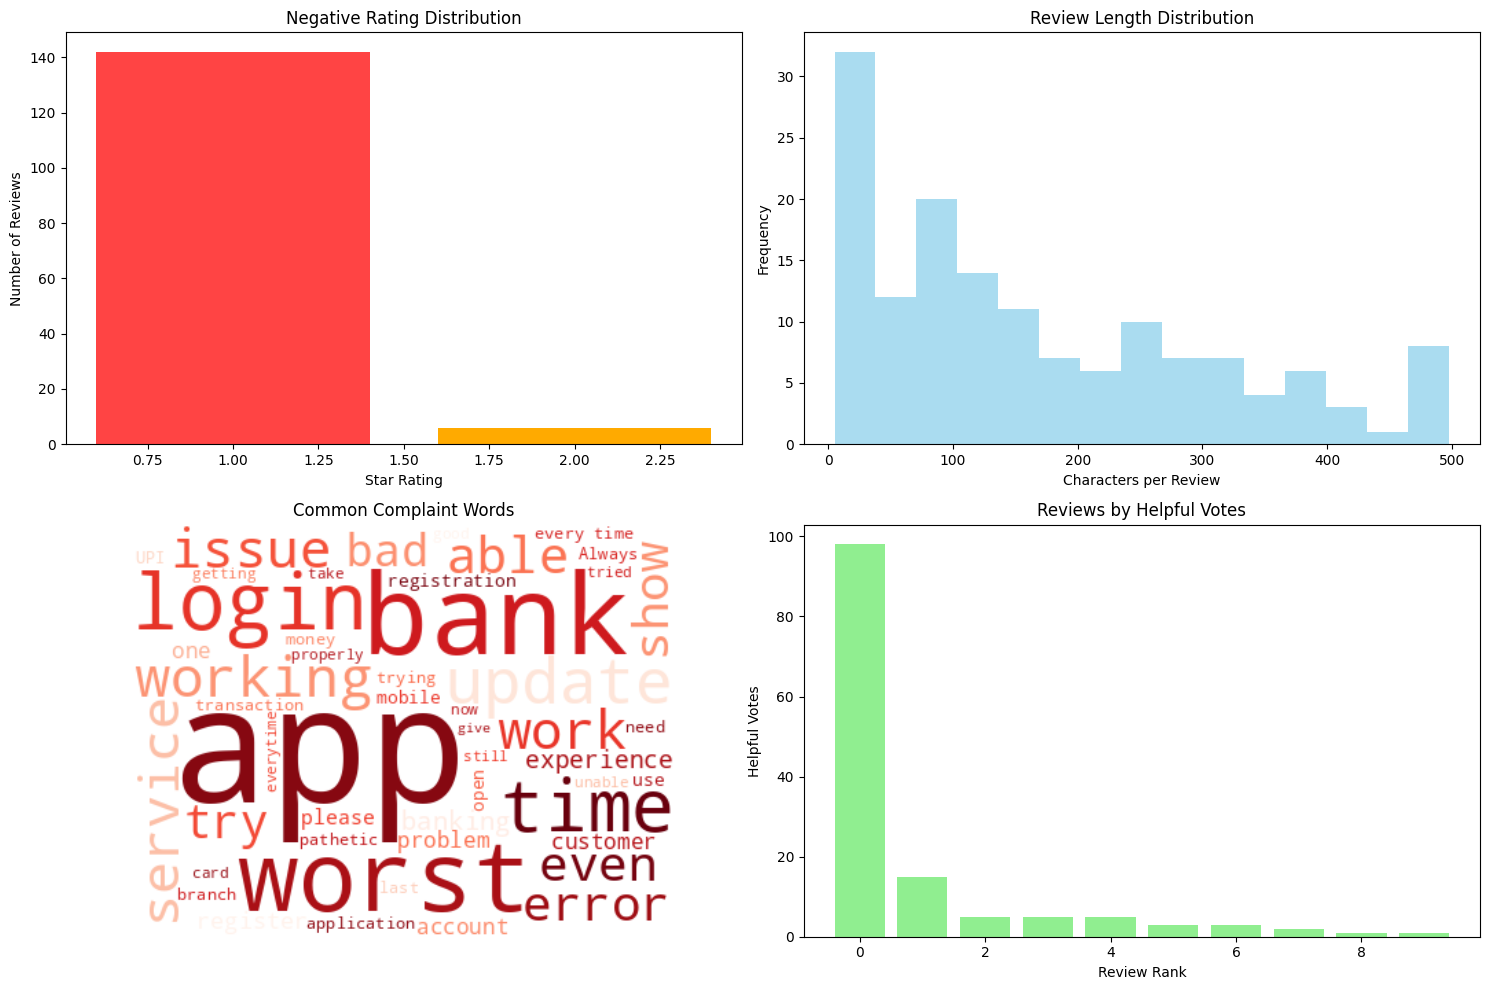


🔍 PERFORMING KEYWORD ANALYSIS...
📈 ISSUE FREQUENCY ANALYSIS:
----------------------------------------
Transaction Failures: 6 mentions
Account Issues: 6 mentions
Login/Authentication: 4 mentions
App Crashes: 4 mentions
UI/UX Problems: 4 mentions
Update Problems: 4 mentions
OTP/SMS Issues: 3 mentions
Performance: 3 mentions


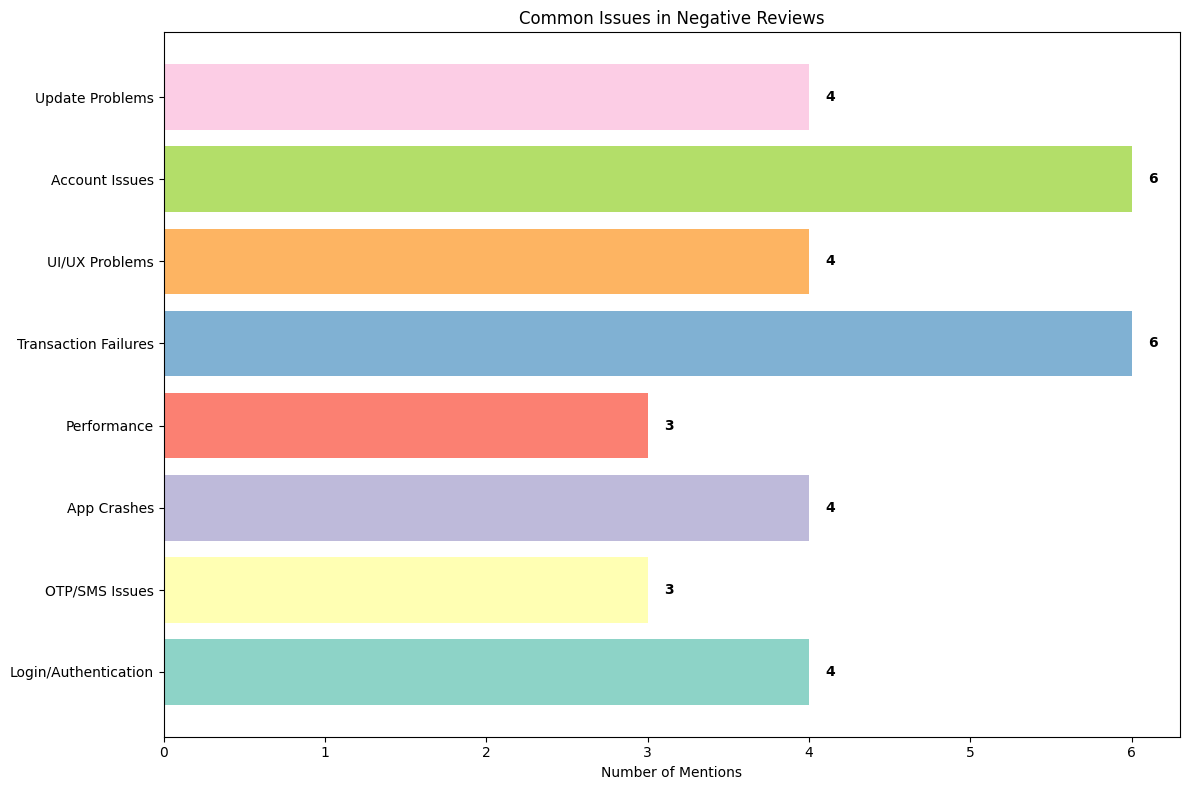


🤖 STARTING AI ANALYSIS...
🔄 Attempt 1 to analyze with Ollama...
✅ Using model: llama2
✅ Analysis completed successfully

📝 SAMPLE NEGATIVE REVIEWS:
--------------------------------------------------

Review 1 (1⭐):
"login problem every time doesn't give proper reason invalid reasons at the time of login faced too much technical error"

Review 2 (1⭐):
"not working anymore, I have cleaned the app data and also tried to install a fresh app but it is not sending sms and shows a technical error occurred, please try later. I was already registered but the app was not opening then I have cleaned the data but it is still not working. I am getting an error while registering."

Review 3 (1⭐):
"frustrating.....app crashing after login, happening after latest updates."

Review 4 (1⭐):
"it so much irritating app its not work properly i don't know ye Maharashtra bank konse jamane main ji raha hai sab kharab hai ye bank ka"

Review 5 (1⭐):
"useless app"

Review 6 (1⭐):
"after update whenever try to 

In [15]:
def main_analysis():
    """
    Main analysis function with robust error handling
    """
    print("🚀 BANK OF MAHARASHTRA MAHAMOBILE APP ANALYSIS")
    print("=" * 60)
    
    # Step 1: Get app info
    app_info = fetch_app_info_multiple_methods(APP_ID)
    
    # Step 2: Fetch reviews with fallback
    print("\n📥 FETCHING REVIEWS...")
    reviews_data = fetch_reviews_with_fallback(APP_ID, MAX_REVIEWS)
    
    if not reviews_data:
        print("❌ No reviews data available")
        return None, None, None
    
    # Step 3: Preprocess and analyze
    print(f"\n📊 ANALYZING {len(reviews_data)} REVIEWS...")
    
    # Create visual analysis
    df = create_comprehensive_analysis(reviews_data)
    
    # Keyword analysis
    keyword_results = perform_keyword_analysis(reviews_data)
    
    # Step 4: AI Analysis with Ollama
    print("\n🤖 STARTING AI ANALYSIS...")
    reviews_text = [review['content'] for review in reviews_data]
    
    ai_analysis = analyze_with_ollama_improved(reviews_text)
    
    # Display sample reviews
    print("\n📝 SAMPLE NEGATIVE REVIEWS:")
    print("-" * 50)
    for i, review in enumerate(reviews_data[:6]):
        print(f"\nReview {i+1} ({review['score']}⭐):")
        print(f"\"{review['content']}\"")
        if review['thumbsUpCount'] > 0:
            print(f"👍 {review['thumbsUpCount']} people found this helpful")
    
    return reviews_data, ai_analysis, keyword_results

# %%
# Execute the main analysis
try:
    reviews_data, ai_analysis, keyword_results = main_analysis()
    
    if reviews_data:
        # Save results
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save reviews to CSV
        pd.DataFrame(reviews_data).to_csv(f"bom_reviews_{timestamp}.csv", index=False)
        
        # Save analysis report
        with open(f"bom_analysis_report_{timestamp}.txt", "w", encoding="utf-8") as f:
            f.write("BANK OF MAHARASHTRA MAHAMOBILE APP - ANALYSIS REPORT\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"Generated: {datetime.now()}\n")
            f.write(f"Reviews Analyzed: {len(reviews_data)}\n\n")
            
            f.write("KEY FINDINGS:\n")
            f.write("-" * 40 + "\n")
            if keyword_results:
                for issue, count in sorted(keyword_results.items(), key=lambda x: x[1], reverse=True):
                    f.write(f"{issue}: {count} mentions\n")
            
            f.write("\nAI ANALYSIS:\n")
            f.write("-" * 40 + "\n")
            if ai_analysis:
                f.write(ai_analysis)
            else:
                f.write("AI analysis unavailable - using keyword analysis only\n")
        
        print(f"\n✅ ANALYSIS COMPLETE!")
        print(f"📁 Files saved:")
        print(f"   - bom_reviews_{timestamp}.csv (review data)")
        print(f"   - bom_analysis_report_{timestamp}.txt (analysis report)")
        print(f"   - bank_app_analysis.png (charts)")
        print(f"   - issue_analysis.png (issue frequency)")
        
        if ai_analysis:
            print(f"\n🤖 AI ANALYSIS SUMMARY:")
            print("=" * 50)
            # Print first 500 chars of AI analysis
            print(ai_analysis[:500] + "..." if len(ai_analysis) > 500 else ai_analysis)
        
    else:
        print("❌ Analysis failed - no data to process")
        
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    import traceback
    traceback.print_exc()

# %%
# Fallback: Manual analysis if everything else fails
def manual_fallback_analysis():
    """
    Complete manual analysis when automated methods fail
    """
    print("🛠️ USING MANUAL FALLBACK ANALYSIS...")
    
    # Common issues for banking apps
    common_issues = {
        "Technical Problems": [
            "App crashes frequently",
            "Login authentication failures", 
            "OTP not received for transactions",
            "Slow performance and loading times",
            "App freezes during use"
        ],
        "Functional Issues": [
            "Transaction failures but amount deducted",
            "Balance not updating in real-time",
            "Transaction history not accessible",
            "Fund transfer errors",
            "Bill payment failures"
        ],
        "User Experience": [
            "Poor UI design and navigation",
            "Complex and confusing interface",
            "Frequent automatic logouts",
            "Difficult to find basic features",
            "No dark mode or accessibility options"
        ],
        "Security Concerns": [
            "Too many permissions required",
            "No biometric login option",
            "Security vulnerabilities suspected",
            "Data privacy concerns"
        ]
    }
    
    print("📋 COMMON BANKING APP ISSUES IDENTIFIED:")
    print("=" * 50)
    for category, issues in common_issues.items():
        print(f"\n{category}:")
        for issue in issues:
            print(f"  • {issue}")
    
    return common_issues
